<a href="https://colab.research.google.com/github/mohammadgh76/Federated-Learning/blob/main/My_First_Federated_Steps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Num users: 6040
Num movies: 3706
OrderedDict([('x', <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[1907],
       [2891],
       [1574],
       [2785],
       [2775]])>), ('y', <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[3.],
       [3.],
       [3.],
       [4.],
       [3.]], dtype=float32)>)])
Train round 0: OrderedDict([('rating_accuracy', 0.0), ('loss', 14.188597)])
Train round 1: OrderedDict([('rating_accuracy', 0.0), ('loss', 14.832584)])
Train round 2: OrderedDict([('rating_accuracy', 0.0), ('loss', 14.063287)])
Train round 3: OrderedDict([('rating_accuracy', 0.004024768), ('loss', 12.170737)])
Train round 4: OrderedDict([('rating_accuracy', 0.045024592), ('loss', 9.104833)])
Train round 5: OrderedDict([('rating_accuracy', 0.10698467), ('loss', 6.147997)])
Train round 6: OrderedDict([('rating_accuracy', 0.1382626), ('loss', 5.4908986)])
Train round 7: OrderedDict([('rating_accuracy', 0.21687117), ('loss', 3.5056307)])
Train round 8: OrderedDict([('rating_accur

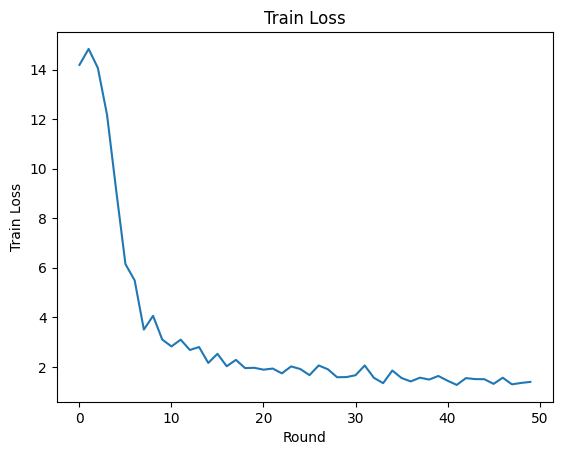

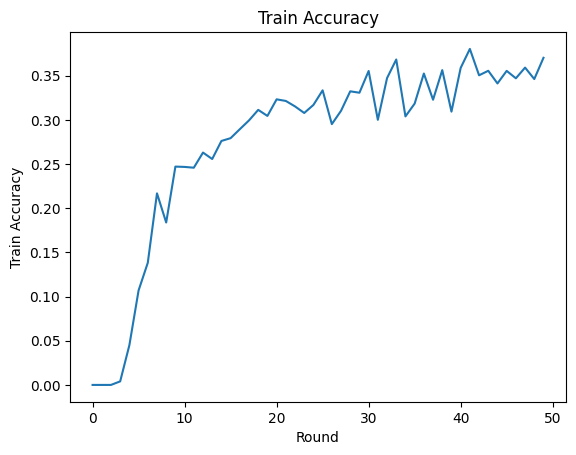

In [4]:
import nest_asyncio
nest_asyncio.apply()

import collections
import functools
import io
import os
import requests
import zipfile
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(42)

def download_movielens_data(dataset_path):
  """Downloads and copies MovieLens data to local /tmp directory."""
  if dataset_path.startswith('http'):
    r = requests.get(dataset_path)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path='/tmp')
  else:
    tf.io.gfile.makedirs('/tmp/ml-1m/')
    for filename in ['ratings.dat', 'movies.dat', 'users.dat']:
      tf.io.gfile.copy(
          os.path.join(dataset_path, filename),
          os.path.join('/tmp/ml-1m/', filename),
          overwrite=True)

download_movielens_data('http://files.grouplens.org/datasets/movielens/ml-1m.zip')

def load_movielens_data(
    data_directory: str = "/tmp",
) -> Tuple[pd.DataFrame, pd.DataFrame]:
  """Loads pandas DataFrames for ratings, movies, users from data directory."""
  # Load pandas DataFrames from data directory. Assuming data is formatted as
  # specified in http://files.grouplens.org/datasets/movielens/ml-1m-README.txt.
  ratings_df = pd.read_csv(
      os.path.join(data_directory, "ml-1m", "ratings.dat"),
      sep="::",
      names=["UserID", "MovieID", "Rating", "Timestamp"], engine="python")
  movies_df = pd.read_csv(
      os.path.join(data_directory, "ml-1m", "movies.dat"),
      sep="::",
      names=["MovieID", "Title", "Genres"], engine="python",
      encoding = "ISO-8859-1")

  # Create dictionaries mapping from old IDs to new (remapped) IDs for both
  # MovieID and UserID. Use the movies and users present in ratings_df to
  # determine the mapping, since movies and users without ratings are unneeded.
  movie_mapping = {
      old_movie: new_movie for new_movie, old_movie in enumerate(
          ratings_df.MovieID.astype("category").cat.categories)
  }
  user_mapping = {
      old_user: new_user for new_user, old_user in enumerate(
          ratings_df.UserID.astype("category").cat.categories)
  }

  # Map each DataFrame consistently using the now-fixed mapping.
  ratings_df.MovieID = ratings_df.MovieID.map(movie_mapping)
  ratings_df.UserID = ratings_df.UserID.map(user_mapping)
  movies_df.MovieID = movies_df.MovieID.map(movie_mapping)

  # Remove nulls resulting from some movies being in movies_df but not
  # ratings_df.
  movies_df = movies_df[pd.notnull(movies_df.MovieID)]

  return ratings_df, movies_df

ratings_df, movies_df = load_movielens_data()
ratings_df.head()
movies_df.head()

print('Num users:', len(set(ratings_df.UserID)))
print('Num movies:', len(set(ratings_df.MovieID)))

def create_tf_datasets(ratings_df: pd.DataFrame,
                       batch_size: int = 1,
                       max_examples_per_user: Optional[int] = None,
                       max_clients: Optional[int] = None) -> List[tf.data.Dataset]:
  """Creates TF Datasets containing the movies and ratings for all users."""
  num_users = len(set(ratings_df.UserID))
  # Optionally limit to `max_clients` to speed up data loading.
  if max_clients is not None:
    num_users = min(num_users, max_clients)

  def rating_batch_map_fn(rating_batch):
    """Maps a rating batch to an OrderedDict with tensor values."""
    # Each example looks like: {x: movie_id, y: rating}.
    # We won't need the UserID since each client will only look at their own
    # data.
    return collections.OrderedDict([
        ("x", tf.cast(rating_batch[:, 1:2], tf.int64)),
        ("y", tf.cast(rating_batch[:, 2:3], tf.float32))
    ])

  tf_datasets = []
  for user_id in range(num_users):
    # Get subset of ratings_df belonging to a particular user.
    user_ratings_df = ratings_df[ratings_df.UserID == user_id]

    tf_dataset = tf.data.Dataset.from_tensor_slices(user_ratings_df)

    # Define preprocessing operations.
    tf_dataset = tf_dataset.take(max_examples_per_user).shuffle(
        buffer_size=max_examples_per_user, seed=42).batch(batch_size).map(
        rating_batch_map_fn,
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    tf_datasets.append(tf_dataset)

  return tf_datasets


def split_tf_datasets(
    tf_datasets: List[tf.data.Dataset],
    train_fraction: float = 0.8,
    val_fraction: float = 0.1,
) -> Tuple[List[tf.data.Dataset], List[tf.data.Dataset], List[tf.data.Dataset]]:
  """Splits a list of user TF datasets into train/val/test by user.
  """
  np.random.seed(42)
  np.random.shuffle(tf_datasets)

  train_idx = int(len(tf_datasets) * train_fraction)
  val_idx = int(len(tf_datasets) * (train_fraction + val_fraction))

  # Note that the val and test data contains completely different users, not
  # just unseen ratings from train users.
  return (tf_datasets[:train_idx], tf_datasets[train_idx:val_idx],
          tf_datasets[val_idx:])

# We limit the number of clients to speed up dataset creation. Feel free to pass
# max_clients=None to load all clients' data.
tf_datasets = create_tf_datasets(
    ratings_df=ratings_df,
    batch_size=5,
    max_examples_per_user=300,
    max_clients=2000)

# Split the ratings into training/val/test by client.
tf_train_datasets, tf_val_datasets, tf_test_datasets = split_tf_datasets(
    tf_datasets,
    train_fraction=0.8,
    val_fraction=0.1)

print(next(iter(tf_train_datasets[0])))


class UserEmbedding(tf.keras.layers.Layer):
  """Keras layer representing an embedding for a single user, used below."""

  def __init__(self, num_latent_factors, **kwargs):
    super().__init__(**kwargs)
    self.num_latent_factors = num_latent_factors

  def build(self, input_shape):
    self.embedding = self.add_weight(
        shape=(1, self.num_latent_factors),
        initializer='uniform',
        dtype=tf.float32,
        name='UserEmbeddingKernel')
    super().build(input_shape)

  def call(self, inputs):
    return self.embedding

  def compute_output_shape(self):
    return (1, self.num_latent_factors)


def get_matrix_factorization_model(
    num_items: int,
    num_latent_factors: int) -> tff.learning.models.ReconstructionModel:
  """Defines a Keras matrix factorization model."""
  # Layers with variables will be partitioned into global and local layers.
  # We'll pass this to `tff.learning.models.ReconstructionModel.from_keras_model_and_layers`.
  global_layers = []
  local_layers = []

  # Extract the item embedding.
  item_input = tf.keras.layers.Input(shape=[1], name='Item')
  item_embedding_layer = tf.keras.layers.Embedding(
      num_items,
      num_latent_factors,
      name='ItemEmbedding')
  global_layers.append(item_embedding_layer)
  flat_item_vec = tf.keras.layers.Flatten(name='FlattenItems')(
      item_embedding_layer(item_input))

  # Extract the user embedding.
  user_embedding_layer = UserEmbedding(
      num_latent_factors,
      name='UserEmbedding')
  local_layers.append(user_embedding_layer)

  # The item_input never gets used by the user embedding layer,
  # but this allows the model to directly use the user embedding.
  flat_user_vec = user_embedding_layer(item_input)

  # Compute the dot product between the user embedding, and the item one.
  pred = tf.keras.layers.Dot(
      1, normalize=False, name='Dot')([flat_user_vec, flat_item_vec])

  input_spec = collections.OrderedDict(
      x=tf.TensorSpec(shape=[None, 1], dtype=tf.int64),
      y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32))

  model = tf.keras.Model(inputs=item_input, outputs=pred)

  return tff.learning.models.ReconstructionModel.from_keras_model_and_layers(
      keras_model=model,
      global_layers=global_layers,
      local_layers=local_layers,
      input_spec=input_spec)

# This will be used to produce our training process.
# User and item embeddings will be 50-dimensional.
model_fn = functools.partial(
    get_matrix_factorization_model,
    num_items=3706,
    num_latent_factors=50)

class RatingAccuracy(tf.keras.metrics.Mean):
  """Keras metric computing accuracy of reconstructed ratings."""

  def __init__(self,
               name: str = 'rating_accuracy',
               **kwargs):
    super().__init__(name=name, **kwargs)

  def update_state(self,
                   y_true: tf.Tensor,
                   y_pred: tf.Tensor,
                   sample_weight: Optional[tf.Tensor] = None):
    absolute_diffs = tf.abs(y_true - y_pred)
    # A [batch_size, 1] tf.bool tensor indicating correctness within the
    # threshold for each example in a batch. A 0.5 threshold corresponds
    # to correctness when predictions are rounded to the nearest whole
    # number.
    example_accuracies = tf.less_equal(absolute_diffs, 0.5)
    super().update_state(example_accuracies, sample_weight=sample_weight)


loss_fn = lambda: tf.keras.losses.MeanSquaredError()
metrics_fn = lambda: [RatingAccuracy()]

# We'll use this by doing:
# state = training_process.initialize()
# state, metrics = training_process.next(state, federated_train_data)
training_process = tff.learning.algorithms.build_fed_recon(
    model_fn=model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0),
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.5),
    reconstruction_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.1))

evaluation_process = tff.learning.algorithms.build_fed_recon_eval(
    model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    reconstruction_optimizer_fn=functools.partial(
            tf.keras.optimizers.SGD, 0.1))

NUM_ROUNDS = 50

train_losses = []
train_accs = []

state = training_process.initialize()

# This may take a couple minutes to run.
for i in range(NUM_ROUNDS):
  federated_train_data = np.random.choice(tf_train_datasets, size=50, replace=False).tolist()
  state, metrics = training_process.next(state, federated_train_data)
  print(f'Train round {i}:', metrics['client_work']['train'])
  train_losses.append(metrics['client_work']['train']['loss'])
  train_accs.append(metrics['client_work']['train']['rating_accuracy'])

plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel('Train Loss')
plt.xlabel('Round')
plt.title('Train Loss')
plt.show()

plt.plot(range(NUM_ROUNDS), train_accs)
plt.ylabel('Train Accuracy')
plt.xlabel('Round')
plt.title('Train Accuracy')
plt.show()


# New Section